## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
# Enable reload of Python modules without Kernel Restart
%load_ext autoreload
%autoreload 2

## CODE

### Load Data

In [3]:
# Working on Data Locally
csv_path = '/home/kaym/code/KayMe1/07-ML-Ops/prelectureMLops/Raw_Data'
raw_data = pd.read_csv(os.path.join(csv_path,"bq-results-20240921-123233-1726921985505.csv"))
raw_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:40:01 UTC,2024-01-01 01:18:26 UTC,2,5.27,1,N,232,246,1,38.0,1.0,0.5,8.60,0.0,1.0,51.60,2.5,0.0
1,1,2024-01-01 00:36:46 UTC,2024-01-01 01:06:46 UTC,1,6.20,1,N,66,146,1,32.4,1.0,0.5,4.50,0.0,1.0,39.40,0.0,0.0
2,2,2024-01-01 00:29:22 UTC,2024-01-01 00:54:36 UTC,1,7.28,1,N,24,79,1,34.5,1.0,0.5,11.85,0.0,1.0,51.35,2.5,0.0
3,2,2024-01-01 00:33:12 UTC,2024-01-01 01:10:05 UTC,2,8.53,1,N,166,255,1,41.5,1.0,0.5,9.30,0.0,1.0,55.80,2.5,0.0
4,2,2024-01-01 00:54:15 UTC,2024-01-01 01:31:18 UTC,1,4.11,1,N,211,141,1,31.7,1.0,0.5,7.34,0.0,1.0,44.04,2.5,0.0


### Data First Look

In [4]:
# Column Names to List
column_names = raw_data.columns.tolist()
column_names

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'store_and_fwd_flag',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee']

In [5]:
def explore_dataframe(df):
    # Create a summary DataFrame with Exploration Results
    summary_df = pd.DataFrame({
        'column_name': df.columns,                 # Column names
        'dtype': df.dtypes,                        # Data types
        'count': [df[col].count() for col in df.columns],  # Count of Valid Values
        'n_unique': df.nunique(),                  # Number of unique values
        'n_missing': df.isna().sum(),              # Number of missing values (NaNs)
        'n_zeros': [(df[col] == 0).sum() if pd.api.types.is_numeric_dtype(df[col]) else None for col in df.columns],  # Number of zeros (for numeric columns)
        'min': [df[col].min() if pd.api.types.is_numeric_dtype(df[col]) else None for col in df.columns],  # Min value (numeric columns only)
        'max': [df[col].max() if pd.api.types.is_numeric_dtype(df[col]) else None for col in df.columns],  # Max value (numeric columns only)
        'mean': [df[col].mean() if pd.api.types.is_numeric_dtype(df[col]) else None for col in df.columns]  # Mean (numeric columns only)
    })

    return summary_df

summary_df = explore_dataframe(raw_data)

In [6]:
summary_df.reset_index(drop=True,inplace=True)
summary_df

,column_name,dtype,count,n_unique,n_missing,n_zeros,min,max,mean
0,VendorID,int64,100000,2,0,0.0,1.00,2.00,1.812380
1,tpep_pickup_datetime,object,100000,95177,0,NaN,NaN,NaN,NaN
2,tpep_dropoff_datetime,object,100000,95057,0,NaN,NaN,NaN,NaN
3,passenger_count,int64,100000,9,0,800.0,0.00,8.00,1.398520
4,trip_distance,float64,100000,3353,0,2775.0,0.00,176.43,9.472839
5,RatecodeID,int64,100000,5,0,0.0,1.00,5.00,1.270990
6,store_and_fwd_flag,object,100000,2,0,NaN,NaN,NaN,NaN
7,PULocationID,int64,100000,210,0,0.0,1.00,265.00,149.204970
8,DOLocationID,int64,100000,259,0,0.0,1.00,265.00,149.942080
9,payment_type,int64,100000,4,0,0.0,1.00,4.00,1.005200


### Inspecting Features

In [7]:
raw_data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,1.81238,1.398520,9.472839,1.270990,149.204970,149.942080,1.005200,45.138863,3.138697,0.465545,10.973042,2.984801,0.995349,65.811186,1.79555,0.802567
std,0.39041,0.888937,5.343976,0.939033,54.793289,77.538209,0.115729,23.423834,2.917869,0.130098,5.914406,4.426263,0.092645,29.511254,1.13226,0.873124
min,1.00000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-700.000000,-7.500000,-0.500000,-80.000000,-20.380000,-1.000000,-695.750000,-2.50000,-1.750000
25%,2.00000,1.000000,6.580000,1.000000,132.000000,88.000000,1.000000,32.400000,0.000000,0.500000,7.560000,0.000000,1.000000,46.900000,0.00000,0.000000
50%,2.00000,1.000000,8.980000,1.000000,138.000000,144.000000,1.000000,39.400000,2.500000,0.500000,10.310000,0.000000,1.000000,63.090000,2.50000,0.000000
75%,2.00000,1.000000,11.150000,1.000000,164.000000,230.000000,1.000000,49.900000,5.000000,0.500000,12.860000,6.940000,1.000000,75.572500,2.50000,1.750000
max,2.00000,8.000000,176.430000,5.000000,265.000000,265.000000,4.000000,450.000000,11.750000,0.500000,300.000000,83.000000,1.000000,586.600000,2.50000,1.750000


In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               100000 non-null  int64  
 1   tpep_pickup_datetime   100000 non-null  object 
 2   tpep_dropoff_datetime  100000 non-null  object 
 3   passenger_count        100000 non-null  int64  
 4   trip_distance          100000 non-null  float64
 5   RatecodeID             100000 non-null  int64  
 6   store_and_fwd_flag     100000 non-null  object 
 7   PULocationID           100000 non-null  int64  
 8   DOLocationID           100000 non-null  int64  
 9   payment_type           100000 non-null  int64  
 10  fare_amount            100000 non-null  float64
 11  extra                  100000 non-null  float64
 12  mta_tax                100000 non-null  float64
 13  tip_amount             100000 non-null  float64
 14  tolls_amount           100000 non-nul

In [9]:
# Coordinate Columns to exclude from distribution
coordinate_columns = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
print(coordinate_columns)
# defining numeric columns ( with exclusion )
numeric_columns = [col for col in raw_data.select_dtypes(exclude=["object"]).columns if col not in coordinate_columns]
print(numeric_columns)

['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']
['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'Airport_fee']


----- Distribution of VendorID : -----


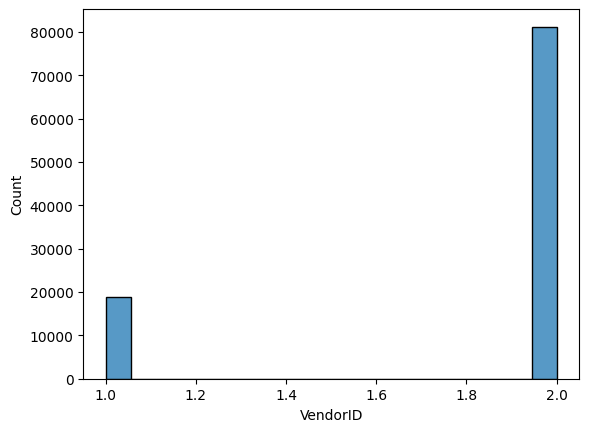

----- Distribution of passenger_count : -----


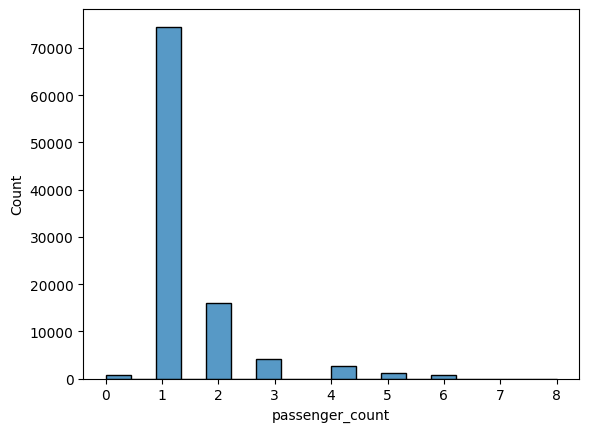

----- Distribution of trip_distance : -----


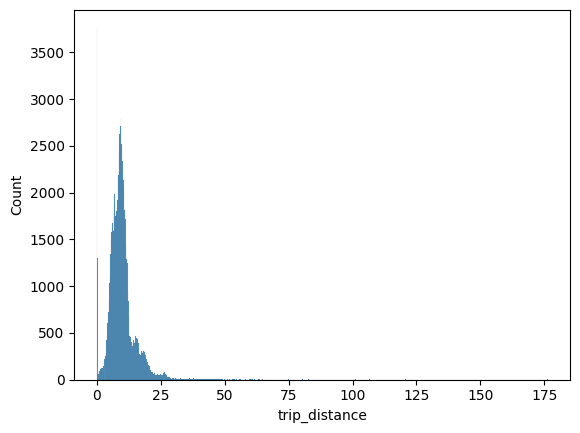

----- Distribution of RatecodeID : -----


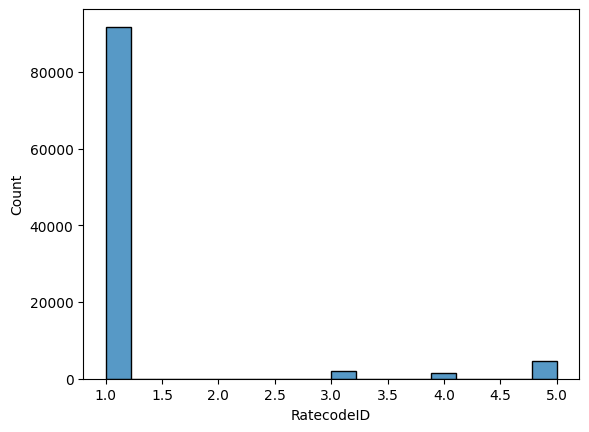

----- Distribution of PULocationID : -----


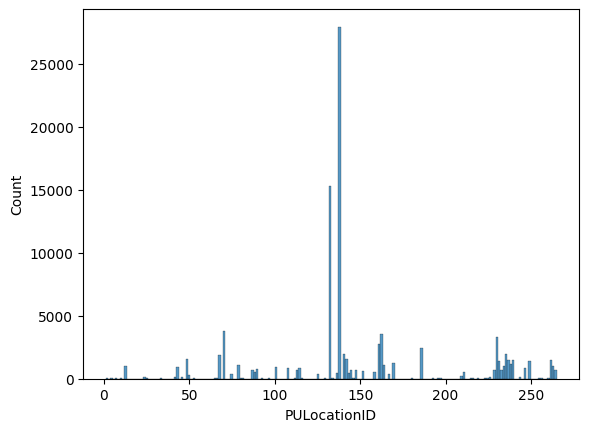

----- Distribution of DOLocationID : -----


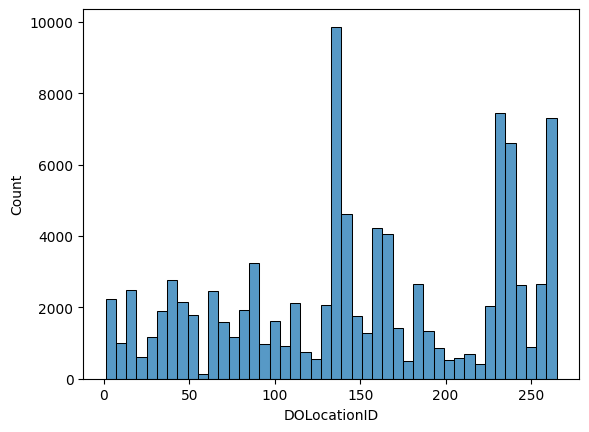

----- Distribution of payment_type : -----


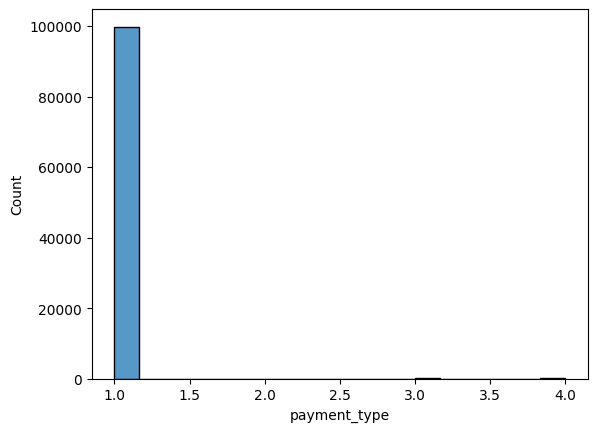

----- Distribution of fare_amount : -----


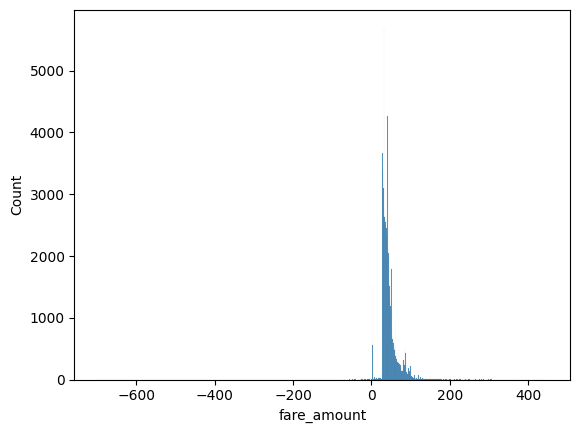

----- Distribution of extra : -----


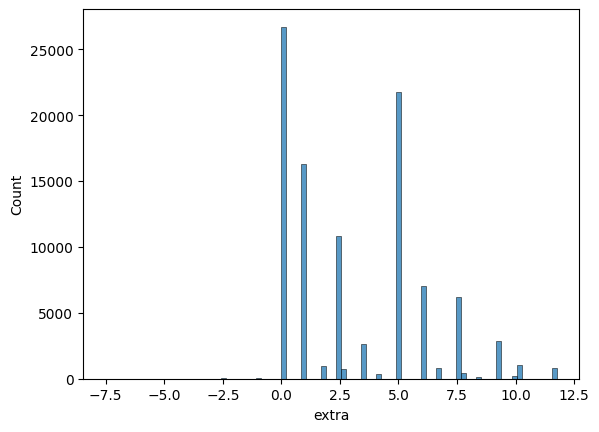

----- Distribution of mta_tax : -----


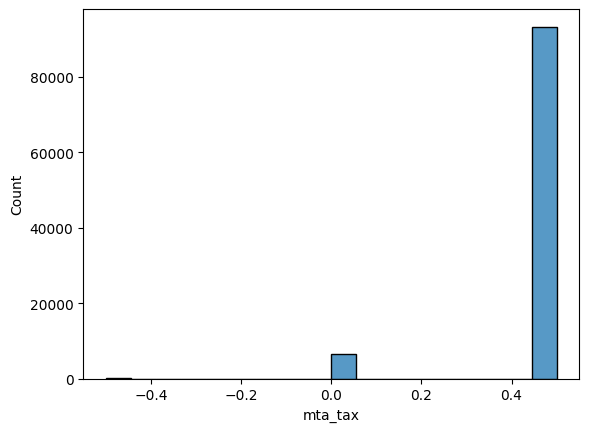

----- Distribution of tip_amount : -----


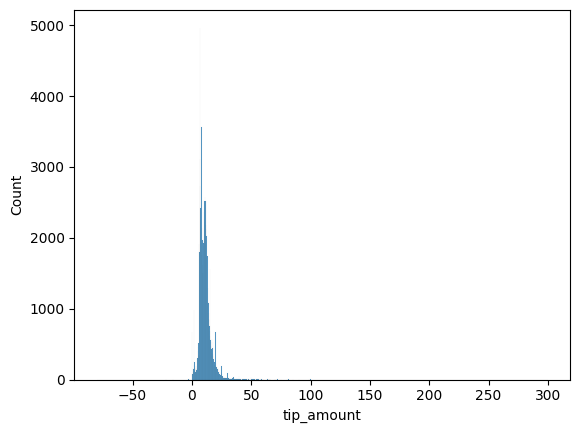

----- Distribution of tolls_amount : -----


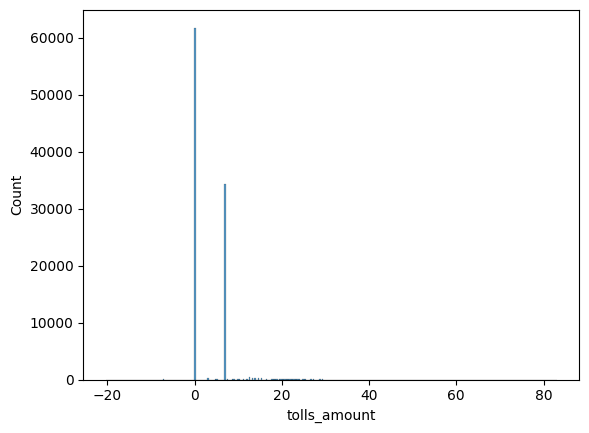

----- Distribution of improvement_surcharge : -----


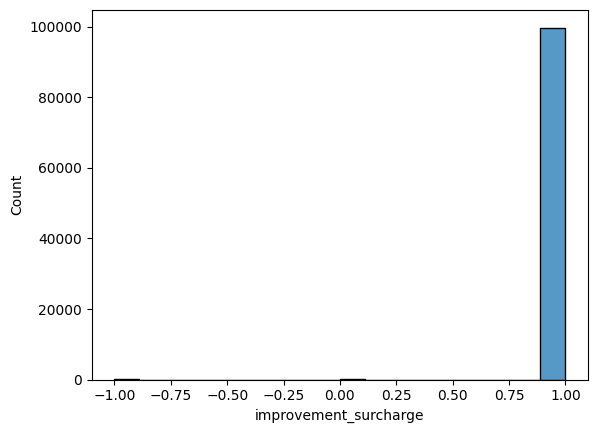

----- Distribution of total_amount : -----


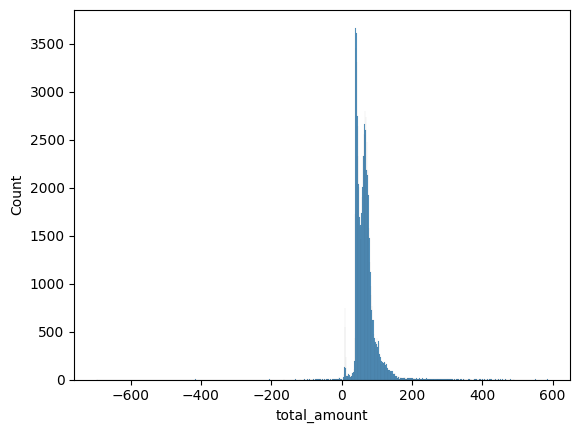

----- Distribution of congestion_surcharge : -----


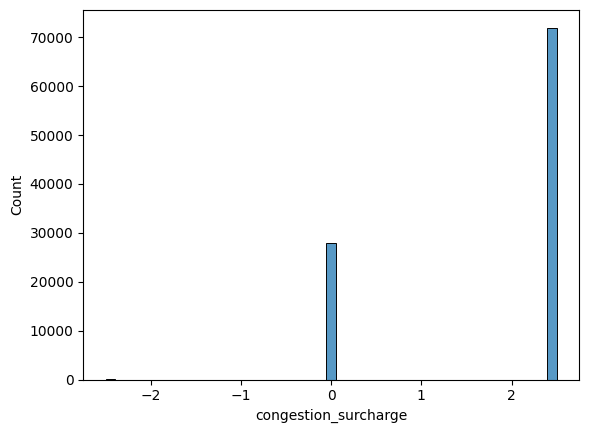

----- Distribution of Airport_fee : -----


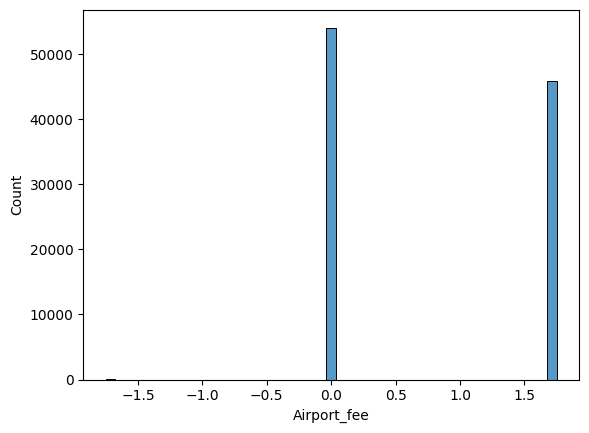

In [10]:
# Plot distribution for the numerical features  available in the dataset
for variable in numeric_columns:
    print(f"----- Distribution of {variable} : -----")
    sns.histplot(raw_data[variable])
    plt.show()

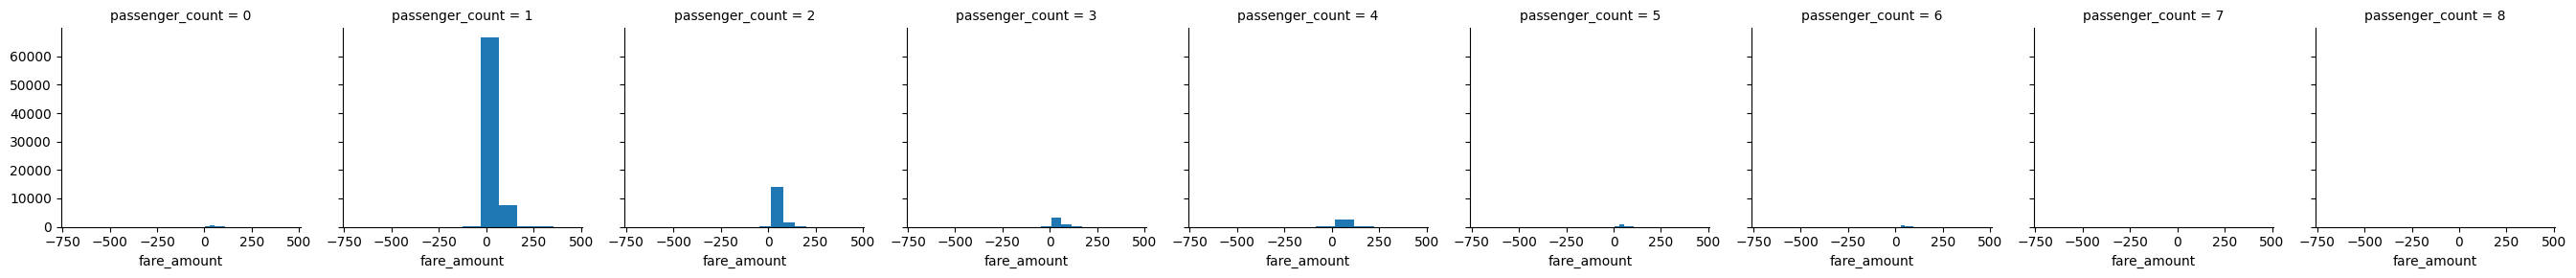

In [11]:
# FacetGrid of histograms for each passenger_count vs. fare_amount
g = sns.FacetGrid(data=raw_data, col="passenger_count")
g.map(plt.hist, "fare_amount")

Kernel Density Estimate (KDE) Interpretation : 
- Peaks in the KDE plot represent areas where the data is concentrated (where values occur more frequently).
- The area under the KDE curve represents the total probability, which sums to 1, similar to a histogram's total bar height.
- It’s useful for understanding the distribution of continuous data and is smoother than a histogram.

----- Distribution of VendorID : -----


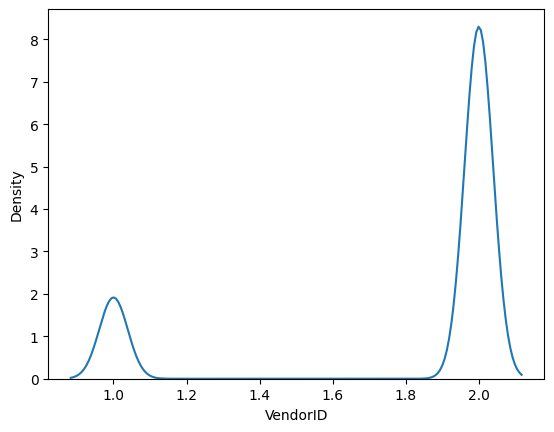

----- Distribution of passenger_count : -----


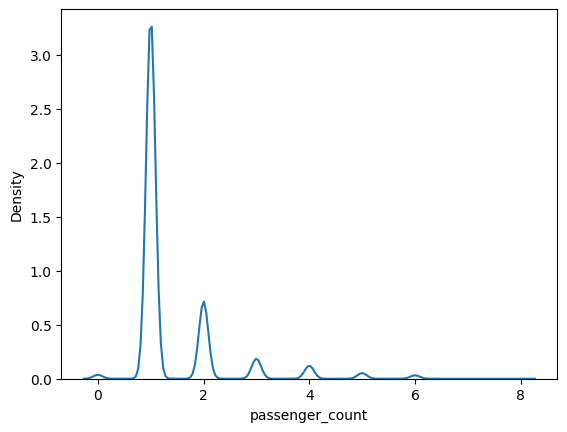

----- Distribution of trip_distance : -----


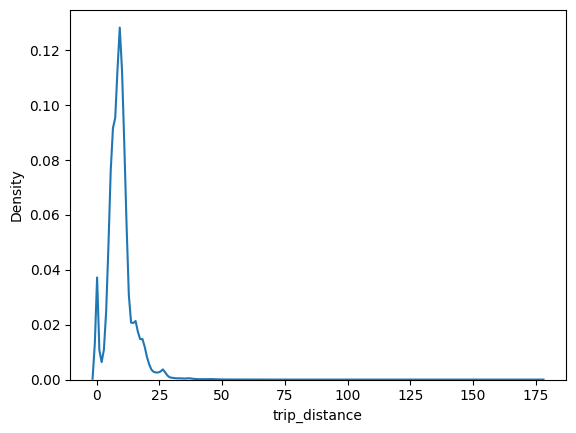

----- Distribution of RatecodeID : -----


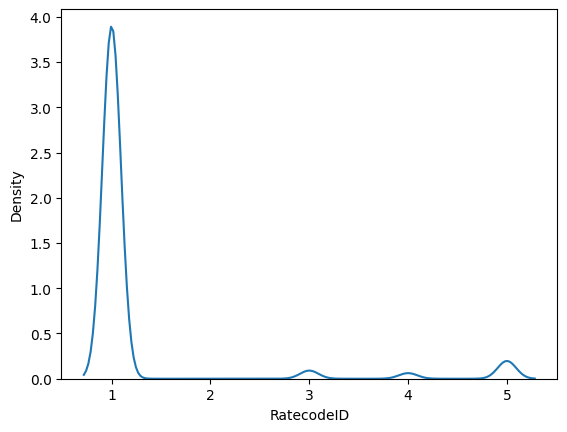

----- Distribution of PULocationID : -----


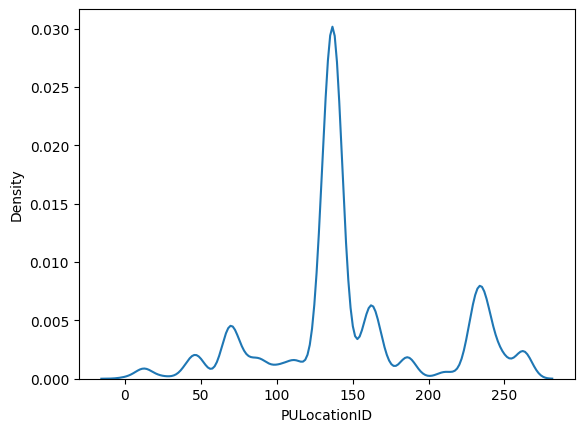

----- Distribution of DOLocationID : -----


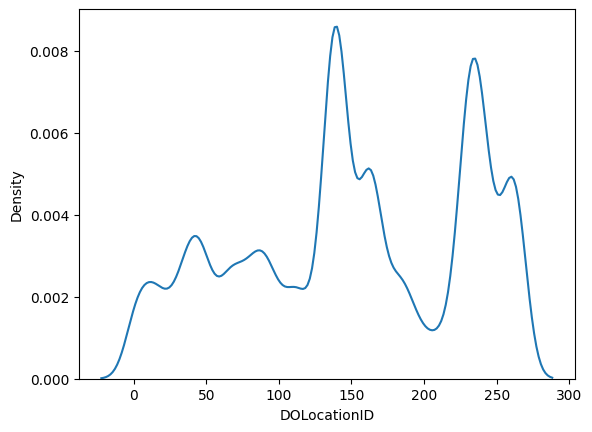

----- Distribution of payment_type : -----


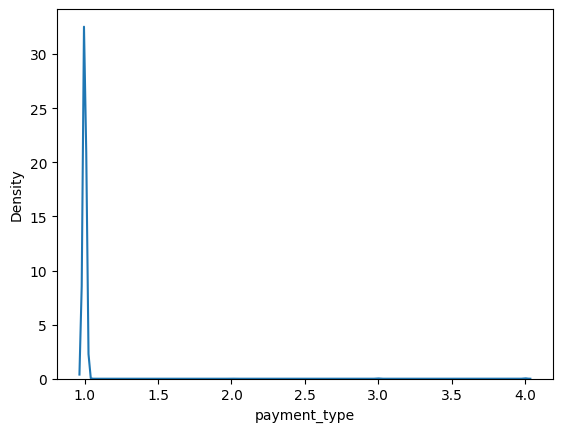

----- Distribution of fare_amount : -----


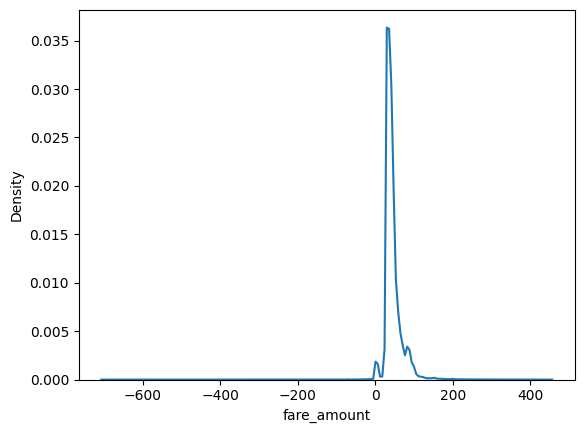

----- Distribution of extra : -----


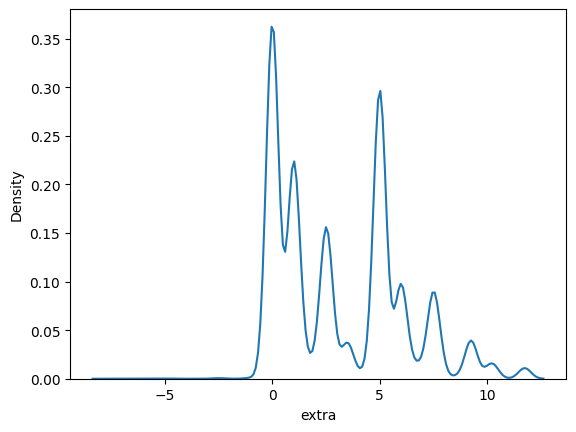

----- Distribution of mta_tax : -----


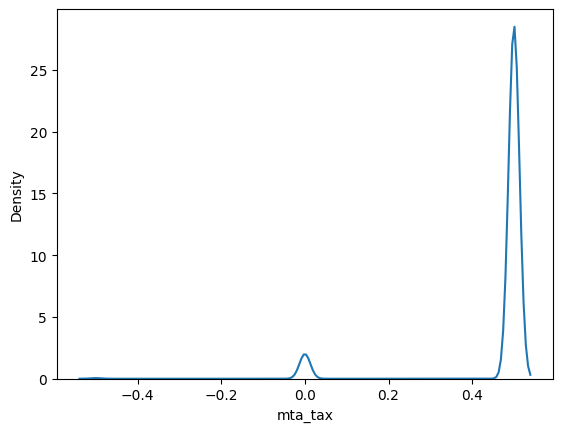

----- Distribution of tip_amount : -----


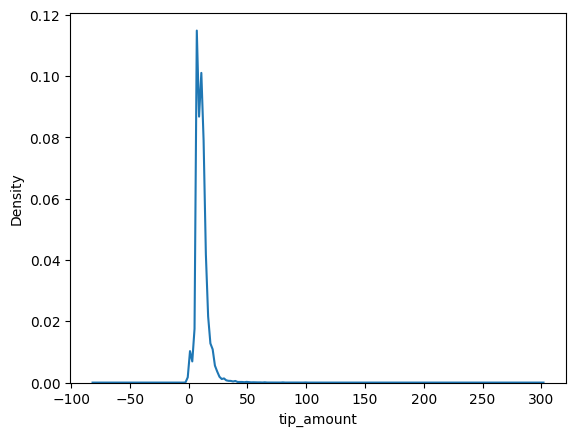

----- Distribution of tolls_amount : -----


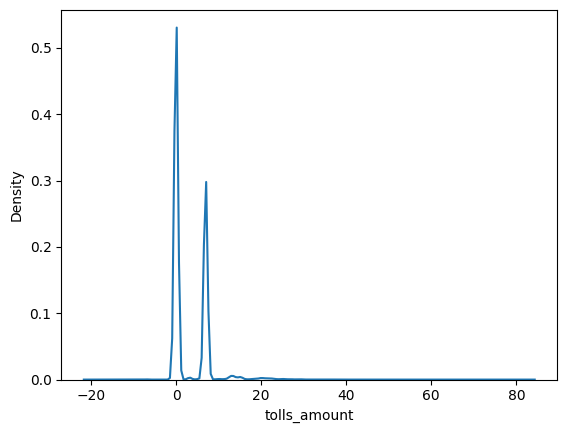

----- Distribution of improvement_surcharge : -----


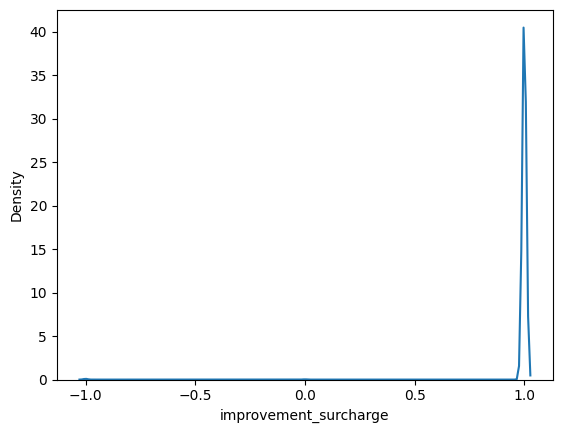

----- Distribution of total_amount : -----


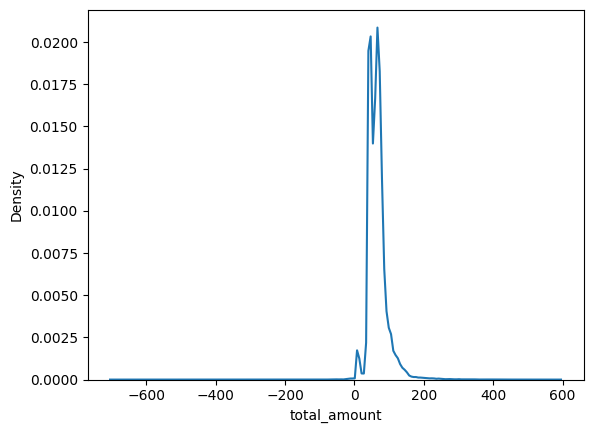

----- Distribution of congestion_surcharge : -----


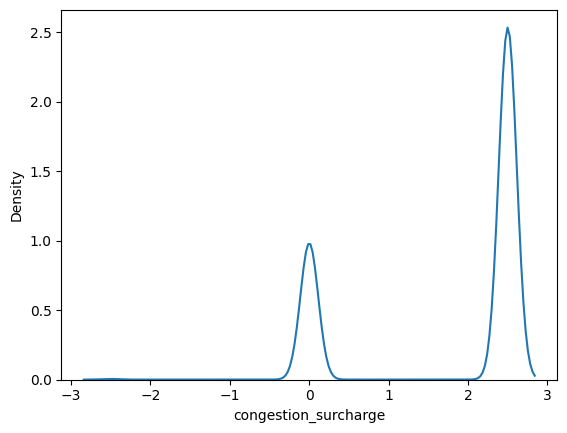

----- Distribution of Airport_fee : -----


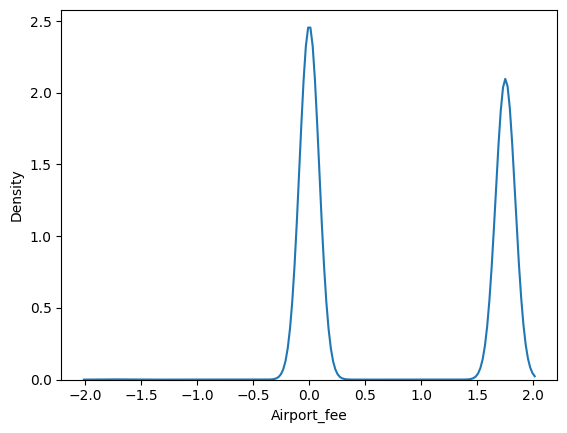

In [12]:
# Kernel Density Estimate (KDE) plot for understanding the distribution of continuous data
for variable in raw_data.select_dtypes(exclude=["object"]).columns:
    print(f"----- Distribution of {variable} : -----")
    sns.kdeplot(raw_data[variable])
    plt.show()

Heatmaps to visualize the correlation between different variables in a dataset --> Explore relationship among numeric values.
- Positive -> when one variable increases, the other one also increases
- Neutral (0) -> No correlation
- Negative -> when one variable increases, the other one decreases

<Axes: >

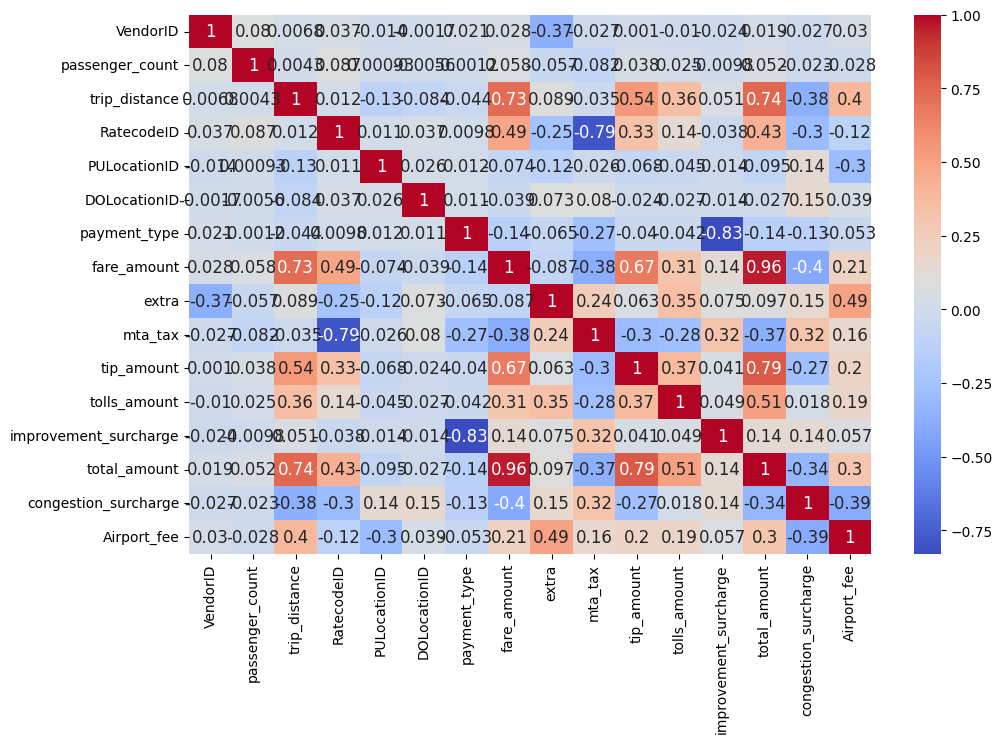

In [13]:
nodate_data = raw_data.select_dtypes(exclude=["object"])

# Correlation plot
plt.figure(figsize=(11,7))
sns.heatmap(
    nodate_data.corr(),
    cmap='coolwarm',
    annot = True,
    annot_kws={"size": 12})

### Pickup Date to Datetime

In [14]:
# redefining numeric columns ( with exclusion )
numeric_columns = [col for col in raw_data.select_dtypes(exclude=["object"]).columns if col not in coordinate_columns]
numeric_columns

['VendorID',
 'passenger_count',
 'trip_distance',
 'RatecodeID',
 'PULocationID',
 'DOLocationID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee']

In [15]:
# New Dataframe based on data_with_distance
data_converted = raw_data.copy()

# Convert 'pickup_datetime'to datetime format
data_converted['tpep_pickup_datetime'] = pd.to_datetime(data_converted['tpep_pickup_datetime'])
data_converted['tpep_dropoff_datetime'] = pd.to_datetime(data_converted['tpep_dropoff_datetime'])

data_converted.dtypes

# data_converted.head()

VendorID                               int64
tpep_pickup_datetime     datetime64[ns, UTC]
tpep_dropoff_datetime    datetime64[ns, UTC]
passenger_count                        int64
trip_distance                        float64
RatecodeID                             int64
store_and_fwd_flag                    object
PULocationID                           int64
DOLocationID                           int64
payment_type                           int64
fare_amount                          float64
extra                                float64
mta_tax                              float64
tip_amount                           float64
tolls_amount                         float64
improvement_surcharge                float64
total_amount                         float64
congestion_surcharge                 float64
Airport_fee                          float64
dtype: object

In [16]:
# Extracting parts of the pickup datetime
data_converted['pickup_year'] = data_converted['tpep_pickup_datetime'].dt.year
data_converted['pickup_month'] = data_converted['tpep_pickup_datetime'].dt.month
data_converted['pickup_day'] = data_converted['tpep_pickup_datetime'].dt.day
data_converted['pickup_hour'] = data_converted['tpep_pickup_datetime'].dt.hour
data_converted['pickup_minute'] = data_converted['tpep_pickup_datetime'].dt.minute
data_converted.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute
0,2,2024-01-01 00:40:01+00:00,2024-01-01 01:18:26+00:00,2,5.27,1,N,232,246,1,...,0.0,1.0,51.60,2.5,0.0,2024,1,1,0,40
1,1,2024-01-01 00:36:46+00:00,2024-01-01 01:06:46+00:00,1,6.20,1,N,66,146,1,...,0.0,1.0,39.40,0.0,0.0,2024,1,1,0,36
2,2,2024-01-01 00:29:22+00:00,2024-01-01 00:54:36+00:00,1,7.28,1,N,24,79,1,...,0.0,1.0,51.35,2.5,0.0,2024,1,1,0,29
3,2,2024-01-01 00:33:12+00:00,2024-01-01 01:10:05+00:00,2,8.53,1,N,166,255,1,...,0.0,1.0,55.80,2.5,0.0,2024,1,1,0,33
4,2,2024-01-01 00:54:15+00:00,2024-01-01 01:31:18+00:00,1,4.11,1,N,211,141,1,...,0.0,1.0,44.04,2.5,0.0,2024,1,1,0,54


In [17]:
# Extracting parts of the dropoff datetime
# data_converted['dropoff_year'] = data_converted['tpep_dropoff_datetime'].dt.year
# data_converted['dropoff_month'] = data_converted['tpep_dropoff_datetime'].dt.month
# data_converted['dropoff_day'] = data_converted['tpep_dropoff_datetime'].dt.day
data_converted['dropoff_hour'] = data_converted['tpep_dropoff_datetime'].dt.hour
data_converted['dropoff_minute'] = data_converted['tpep_dropoff_datetime'].dt.minute
data_converted.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,congestion_surcharge,Airport_fee,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,dropoff_hour,dropoff_minute
0,2,2024-01-01 00:40:01+00:00,2024-01-01 01:18:26+00:00,2,5.27,1,N,232,246,1,...,51.60,2.5,0.0,2024,1,1,0,40,1,18
1,1,2024-01-01 00:36:46+00:00,2024-01-01 01:06:46+00:00,1,6.20,1,N,66,146,1,...,39.40,0.0,0.0,2024,1,1,0,36,1,6
2,2,2024-01-01 00:29:22+00:00,2024-01-01 00:54:36+00:00,1,7.28,1,N,24,79,1,...,51.35,2.5,0.0,2024,1,1,0,29,0,54
3,2,2024-01-01 00:33:12+00:00,2024-01-01 01:10:05+00:00,2,8.53,1,N,166,255,1,...,55.80,2.5,0.0,2024,1,1,0,33,1,10
4,2,2024-01-01 00:54:15+00:00,2024-01-01 01:31:18+00:00,1,4.11,1,N,211,141,1,...,44.04,2.5,0.0,2024,1,1,0,54,1,31


In [18]:
# Calculate the travel time
data_converted['travel_time'] = data_converted['tpep_dropoff_datetime'] - data_converted['tpep_pickup_datetime']

# Convert the 'travel_time' to minutes
data_converted['travel_time_minutes'] = data_converted['travel_time'].dt.total_seconds() / 60

# Preview the updated DataFrame
data_converted.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,Airport_fee,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,dropoff_hour,dropoff_minute,travel_time,travel_time_minutes
0,2,2024-01-01 00:40:01+00:00,2024-01-01 01:18:26+00:00,2,5.27,1,N,232,246,1,...,0.0,2024,1,1,0,40,1,18,0 days 00:38:25,38.416667
1,1,2024-01-01 00:36:46+00:00,2024-01-01 01:06:46+00:00,1,6.20,1,N,66,146,1,...,0.0,2024,1,1,0,36,1,6,0 days 00:30:00,30.000000
2,2,2024-01-01 00:29:22+00:00,2024-01-01 00:54:36+00:00,1,7.28,1,N,24,79,1,...,0.0,2024,1,1,0,29,0,54,0 days 00:25:14,25.233333
3,2,2024-01-01 00:33:12+00:00,2024-01-01 01:10:05+00:00,2,8.53,1,N,166,255,1,...,0.0,2024,1,1,0,33,1,10,0 days 00:36:53,36.883333
4,2,2024-01-01 00:54:15+00:00,2024-01-01 01:31:18+00:00,1,4.11,1,N,211,141,1,...,0.0,2024,1,1,0,54,1,31,0 days 00:37:03,37.050000


In [19]:
# Function to classify as day or night
def classify_day_night(hour):
    if 7 <= hour <= 20:
        return 'day'
    else:
        return 'night'

# Apply the function to new 'pickup_hour' column
data_converted['pickup_period'] = data_converted['pickup_hour'].apply(classify_day_night)
data_converted['dropoff_period'] = data_converted['dropoff_hour'].apply(classify_day_night)

data_converted.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,pickup_month,pickup_day,pickup_hour,pickup_minute,dropoff_hour,dropoff_minute,travel_time,travel_time_minutes,pickup_period,dropoff_period
0,2,2024-01-01 00:40:01+00:00,2024-01-01 01:18:26+00:00,2,5.27,1,N,232,246,1,...,1,1,0,40,1,18,0 days 00:38:25,38.416667,night,night
1,1,2024-01-01 00:36:46+00:00,2024-01-01 01:06:46+00:00,1,6.20,1,N,66,146,1,...,1,1,0,36,1,6,0 days 00:30:00,30.000000,night,night
2,2,2024-01-01 00:29:22+00:00,2024-01-01 00:54:36+00:00,1,7.28,1,N,24,79,1,...,1,1,0,29,0,54,0 days 00:25:14,25.233333,night,night
3,2,2024-01-01 00:33:12+00:00,2024-01-01 01:10:05+00:00,2,8.53,1,N,166,255,1,...,1,1,0,33,1,10,0 days 00:36:53,36.883333,night,night
4,2,2024-01-01 00:54:15+00:00,2024-01-01 01:31:18+00:00,1,4.11,1,N,211,141,1,...,1,1,0,54,1,31,0 days 00:37:03,37.050000,night,night


In [20]:
# Dropping Distance_Euclidean_Degrees
data_transformed = data_converted.drop(columns=["store_and_fwd_flag",
                                                "tpep_pickup_datetime",
                                                "tpep_dropoff_datetime",
                                                "travel_time",
                                                "pickup_hour","pickup_month","pickup_day","pickup_minute",
                                                "dropoff_hour","dropoff_minute",
                                                "PULocationID","DOLocationID"])
data_transformed.head()

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,pickup_year,travel_time_minutes,pickup_period,dropoff_period
0,2,2,5.27,1,1,38.0,1.0,0.5,8.60,0.0,1.0,51.60,2.5,0.0,2024,38.416667,night,night
1,1,1,6.20,1,1,32.4,1.0,0.5,4.50,0.0,1.0,39.40,0.0,0.0,2024,30.000000,night,night
2,2,1,7.28,1,1,34.5,1.0,0.5,11.85,0.0,1.0,51.35,2.5,0.0,2024,25.233333,night,night
3,2,2,8.53,1,1,41.5,1.0,0.5,9.30,0.0,1.0,55.80,2.5,0.0,2024,36.883333,night,night
4,2,1,4.11,1,1,31.7,1.0,0.5,7.34,0.0,1.0,44.04,2.5,0.0,2024,37.050000,night,night


In [21]:
# Calculate price per kilometer (fare_amount / distance_haversine_km)
data_transformed['price_per_km'] = data_transformed['fare_amount'] / data_transformed['trip_distance']

# @@@ Distance 0 to be taken into account
datadist_nonzero = data_transformed[data_transformed["trip_distance"] != 0]
datadist_nonzero


,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,pickup_year,travel_time_minutes,pickup_period,dropoff_period,price_per_km
0,2,2,5.27,1,1,38.0,1.0,0.5,8.60,0.0,1.0,51.60,2.5,0.0,2024,38.416667,night,night,7.210626
1,1,1,6.20,1,1,32.4,1.0,0.5,4.50,0.0,1.0,39.40,0.0,0.0,2024,30.000000,night,night,5.225806
2,2,1,7.28,1,1,34.5,1.0,0.5,11.85,0.0,1.0,51.35,2.5,0.0,2024,25.233333,night,night,4.739011
3,2,2,8.53,1,1,41.5,1.0,0.5,9.30,0.0,1.0,55.80,2.5,0.0,2024,36.883333,night,night,4.865182
4,2,1,4.11,1,1,31.7,1.0,0.5,7.34,0.0,1.0,44.04,2.5,0.0,2024,37.050000,night,night,7.712895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2,1,4.88,1,1,35.2,0.0,0.5,7.84,0.0,1.0,47.04,2.5,0.0,2024,40.466667,day,day,7.213115
99996,1,1,3.80,1,1,33.1,2.5,0.5,11.15,0.0,1.0,48.25,2.5,0.0,2024,41.366667,day,day,8.710526
99997,2,1,2.21,1,1,31.7,0.0,0.5,7.14,0.0,1.0,42.84,2.5,0.0,2024,39.266667,day,day,14.343891
99998,1,1,4.60,1,1,48.5,2.5,0.5,10.50,0.0,1.0,63.00,2.5,0.0,2024,79.716667,day,day,10.543478


### Inspecting Features ( new DB : data_transformed)

In [22]:
# redefining numeric columns ( with exclusion )
numeric_columns = [col for col in datadist_nonzero.select_dtypes(exclude=["object"]).columns if col not in coordinate_columns]
# Slicing List to get desired features
numeric_features = numeric_columns[1:]
numeric_features

['passenger_count',
 'trip_distance',
 'RatecodeID',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount',
 'congestion_surcharge',
 'Airport_fee',
 'pickup_year',
 'travel_time_minutes',
 'price_per_km']

In [23]:
# Indices of elements to remove: 2, 3, 6, 8, 9, 12
indices_to_remove = [2, 3, 6, 8, 9, 12,13]

numeric_features = [item for idx, item in enumerate(numeric_features) if idx not in indices_to_remove]

numeric_features

['passenger_count',
 'trip_distance',
 'fare_amount',
 'extra',
 'tip_amount',
 'total_amount',
 'congestion_surcharge',
 'travel_time_minutes',
 'price_per_km']

<Axes: >

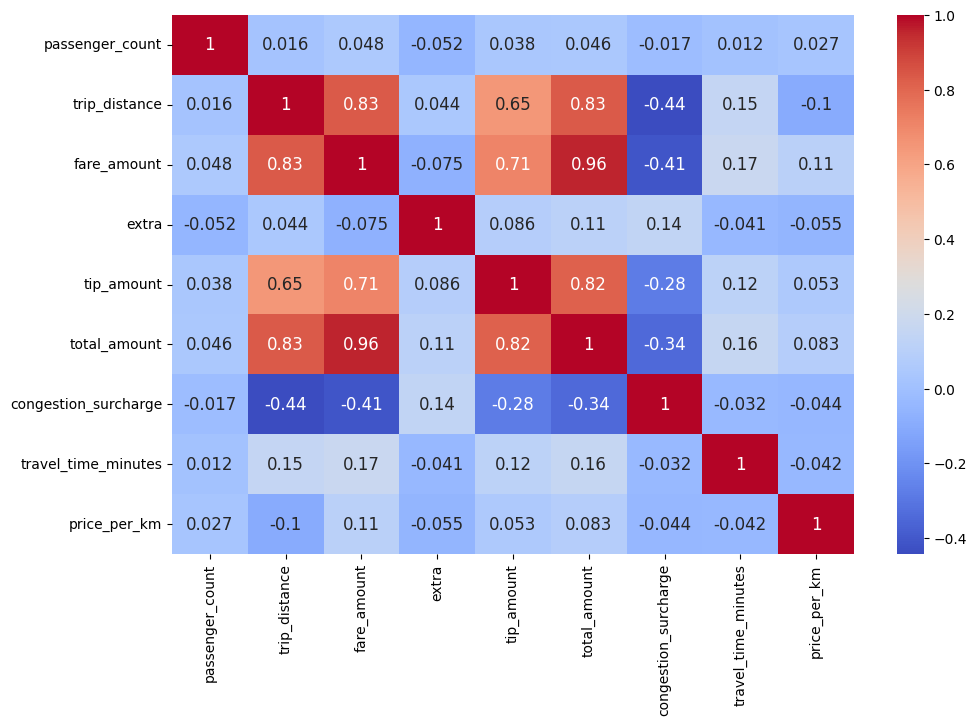

In [24]:
# Correlation plot
plt.figure(figsize=(11,7))
sns.heatmap(
    datadist_nonzero[numeric_features].corr(),
    cmap='coolwarm',
    annot = True,
    annot_kws={"size": 12})

REMARQUES 
> Correlation Between 
  > trip_distance / fare_amount OR total_amount
  > tip_amount / fare_amount OR total_amount
  > trip_distance / tip_amount OR total_amount

### Multivariate regression

In [25]:
numeric_features.remove('fare_amount')

In [26]:
numeric_features.remove('total_amount')

In [27]:
numeric_features.remove('tip_amount')

In [28]:
numeric_features.remove('price_per_km')

In [29]:
features = numeric_features
features

['passenger_count',
 'trip_distance',
 'extra',
 'congestion_surcharge',
 'travel_time_minutes']

In [30]:
# Standardizing the features
data_standardized = datadist_nonzero.copy()
for f in features:
    mu = datadist_nonzero[f].mean()
    sigma = datadist_nonzero[f].std()
    data_standardized[f] = datadist_nonzero[f].map(lambda x: (x - mu) / sigma)
data_standardized

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,pickup_year,travel_time_minutes,pickup_period,dropoff_period,price_per_km
0,2,0.687380,-0.865064,1,1,38.0,-0.760789,0.5,8.60,0.0,1.0,51.60,0.609249,0.0,2024,0.238503,night,night,7.210626
1,1,-0.445168,-0.685213,1,1,32.4,-0.760789,0.5,4.50,0.0,1.0,39.40,-1.620368,0.0,2024,0.002351,night,night,5.225806
2,2,-0.445168,-0.476355,1,1,34.5,-0.760789,0.5,11.85,0.0,1.0,51.35,0.609249,0.0,2024,-0.131390,night,night,4.739011
3,2,0.687380,-0.234620,1,1,41.5,-0.760789,0.5,9.30,0.0,1.0,55.80,0.609249,0.0,2024,0.195481,night,night,4.865182
4,2,-0.445168,-1.089393,1,1,31.7,-0.760789,0.5,7.34,0.0,1.0,44.04,0.609249,0.0,2024,0.200158,night,night,7.712895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2,-0.445168,-0.940485,1,1,35.2,-1.103996,0.5,7.84,0.0,1.0,47.04,0.609249,0.0,2024,0.296021,day,day,7.213115
99996,1,-0.445168,-1.149344,1,1,33.1,-0.245978,0.5,11.15,0.0,1.0,48.25,0.609249,0.0,2024,0.321273,day,day,8.710526
99997,2,-0.445168,-1.456830,1,1,31.7,-1.103996,0.5,7.14,0.0,1.0,42.84,0.609249,0.0,2024,0.262352,day,day,14.343891
99998,1,-0.445168,-0.994633,1,1,48.5,-0.245978,0.5,10.50,0.0,1.0,63.00,0.609249,0.0,2024,1.397283,day,day,10.543478


In [31]:
# Creating Model
formula = "fare_amount ~ " + ' + '.join(features)
formula

'fare_amount ~ passenger_count + trip_distance + extra + congestion_surcharge + travel_time_minutes'

In [32]:
model = smf.ols(formula = formula, data = data_standardized).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                 4.757e+04
Date:                Thu, 26 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:44:07   Log-Likelihood:            -3.8032e+05
No. Observations:               97225   AIC:                         7.607e+05
Df Residuals:                   97219   BIC:                         7.607e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               44.7992 

<Axes: >

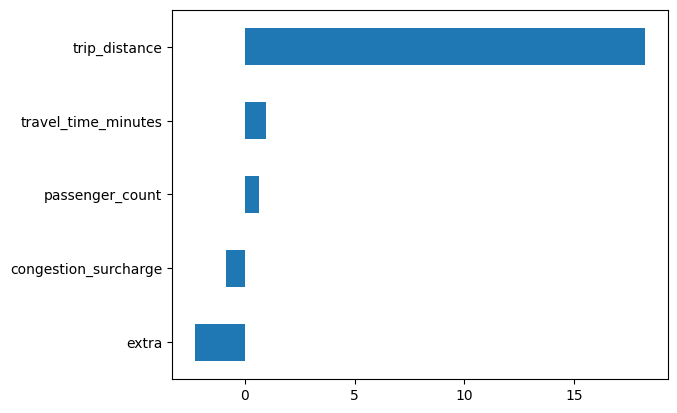

In [33]:
model.params[1:].sort_values().plot(kind='barh')

In [34]:
predicted_fare_amount = model.predict(data_standardized[features])
residuals = predicted_fare_amount - data_standardized.fare_amount

In [35]:
# Compute the associated RMSE.
rmse = (residuals**2).mean()**0.5
rmse

12.095382250429328

An RMSE of 10 means that, on average, the predictions are off by 10 units from the actual values.

Text(0.5, 1.0, 'residuals density plot')

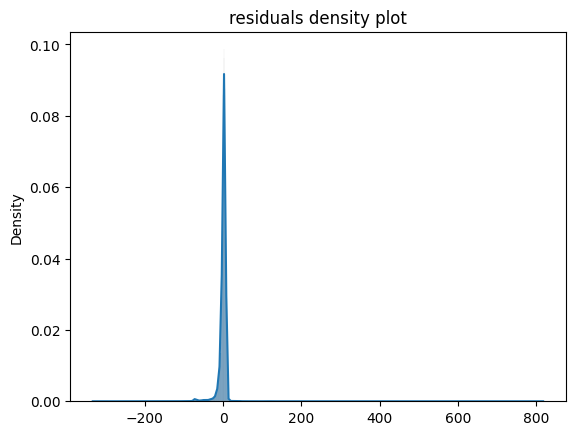

In [36]:
# Residuals in a Histogram
sns.histplot(residuals, kde=True, stat='density', discrete=True)
plt.title('residuals density plot')

Normal Residual Distribution --> well-performing model, residuals  normally distributed and centered around 0. 
This indicates that errors are randomly distributed, with the model performing well across all ranges of the target variable.

Text(0.5, 1.0, 'distribution of predicted and actual values')

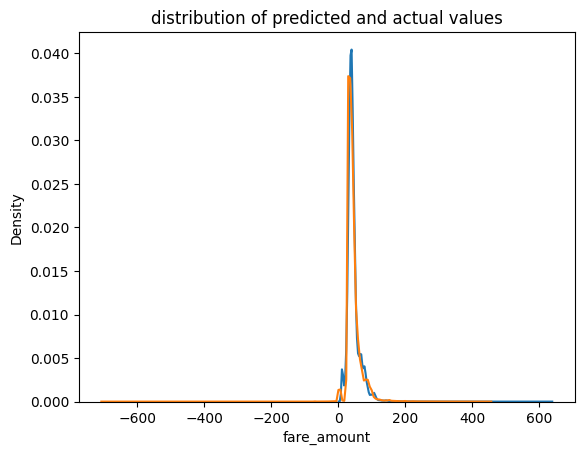

In [37]:
# Plot, on the same graph, both the distribution of the fare_amount and the distribution of the predicted_fare_amount.
sns.kdeplot(predicted_fare_amount, label='predicted fare amount')
sns.kdeplot(datadist_nonzero.fare_amount, label = 'actual fare amount')
plt.title('distribution of predicted and actual values')

The distribution of predicted and actual values is offset to the right of 0 on the residuals density plot, it indicates that model tends to underestimate the actual values --> the model has a bias towards lower predictions

(0.0, 321.1147615129818)

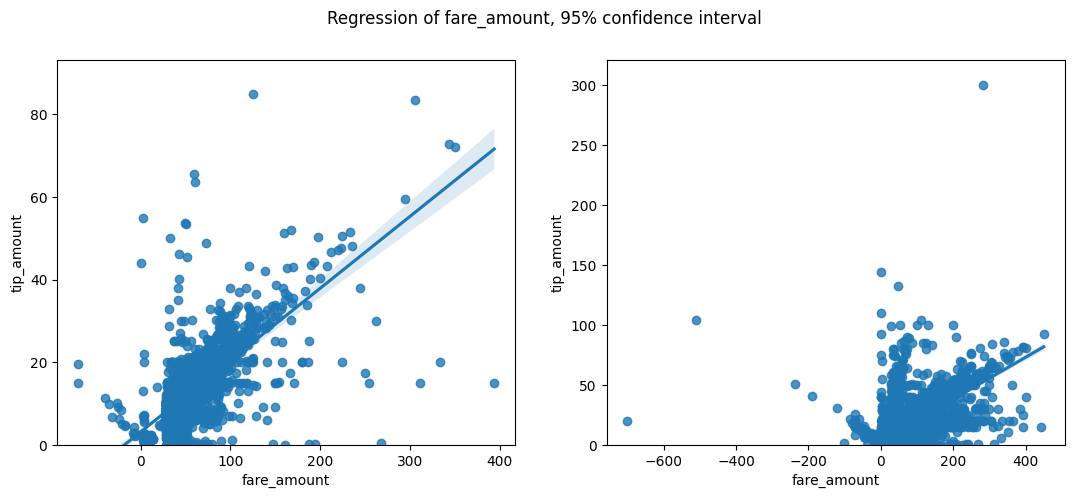

In [38]:
sample = datadist_nonzero.sample(10000, random_state=42)
plt.figure(figsize=(13,5))
plt.suptitle('Regression of fare_amount, 95% confidence interval')
plt.subplot(1,2,1)
sns.regplot(x = sample.fare_amount, y= sample.tip_amount, y_jitter=.1, ci=95)
# plt.xlim(right=100)
plt.ylim(bottom=0)

plt.subplot(1,2,2)
sns.regplot(x = datadist_nonzero.fare_amount, y= datadist_nonzero.tip_amount, y_jitter=.1, ci=95)
# plt.xlim(left=-200)
plt.ylim(bottom=0)

### Machine Learning : K-Nearest Neighbors (KNN)

The K-Nearest Neighbors (KNN) : simple, intuitive, and widely-used machine learning algorithm for both classification and regression tasks

In [39]:
# Count number of duplicated rows
duplicate_count = datadist_nonzero.duplicated().sum()
duplicate_count

85

In [40]:
data = datadist_nonzero.drop_duplicates()
len(data)
duplicate_count_data = data.duplicated().sum()
duplicate_count_data

0

In [41]:
# Counting number of missing data for each column
missing_data = data.isnull().sum().sort_values(ascending=False)
missing_data

VendorID                 0
improvement_surcharge    0
dropoff_period           0
pickup_period            0
travel_time_minutes      0
pickup_year              0
Airport_fee              0
congestion_surcharge     0
total_amount             0
tolls_amount             0
passenger_count          0
tip_amount               0
mta_tax                  0
extra                    0
fare_amount              0
payment_type             0
RatecodeID               0
trip_distance            0
price_per_km             0
dtype: int64

--> No Missing Values ( NaN )

Split the dataset to create your X_train X_test and y_train y_test. Using:
test_size=0.3
random_state=0

In [42]:
data

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,pickup_year,travel_time_minutes,pickup_period,dropoff_period,price_per_km
0,2,2,5.27,1,1,38.0,1.0,0.5,8.60,0.0,1.0,51.60,2.5,0.0,2024,38.416667,night,night,7.210626
1,1,1,6.20,1,1,32.4,1.0,0.5,4.50,0.0,1.0,39.40,0.0,0.0,2024,30.000000,night,night,5.225806
2,2,1,7.28,1,1,34.5,1.0,0.5,11.85,0.0,1.0,51.35,2.5,0.0,2024,25.233333,night,night,4.739011
3,2,2,8.53,1,1,41.5,1.0,0.5,9.30,0.0,1.0,55.80,2.5,0.0,2024,36.883333,night,night,4.865182
4,2,1,4.11,1,1,31.7,1.0,0.5,7.34,0.0,1.0,44.04,2.5,0.0,2024,37.050000,night,night,7.712895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2,1,4.88,1,1,35.2,0.0,0.5,7.84,0.0,1.0,47.04,2.5,0.0,2024,40.466667,day,day,7.213115
99996,1,1,3.80,1,1,33.1,2.5,0.5,11.15,0.0,1.0,48.25,2.5,0.0,2024,41.366667,day,day,8.710526
99997,2,1,2.21,1,1,31.7,0.0,0.5,7.14,0.0,1.0,42.84,2.5,0.0,2024,39.266667,day,day,14.343891
99998,1,1,4.60,1,1,48.5,2.5,0.5,10.50,0.0,1.0,63.00,2.5,0.0,2024,79.716667,day,day,10.543478


In [43]:
# Mapping for the encoding
day_night_mapping = {'day': 0, 'night': 1}

# Apply the mapping to encode
data['pickup_period_encoded'] = data['pickup_period'].map(day_night_mapping)
data['dropoff_period_encoded'] = data['dropoff_period'].map(day_night_mapping)

data

/tmp/ipykernel_548472/4245517745.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pickup_period_encoded'] = data['pickup_period'].map(day_night_mapping)
/tmp/ipykernel_548472/4245517745.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['dropoff_period_encoded'] = data['dropoff_period'].map(day_night_mapping)


,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,...,total_amount,congestion_surcharge,Airport_fee,pickup_year,travel_time_minutes,pickup_period,dropoff_period,price_per_km,pickup_period_encoded,dropoff_period_encoded
0,2,2,5.27,1,1,38.0,1.0,0.5,8.60,0.0,...,51.60,2.5,0.0,2024,38.416667,night,night,7.210626,1,1
1,1,1,6.20,1,1,32.4,1.0,0.5,4.50,0.0,...,39.40,0.0,0.0,2024,30.000000,night,night,5.225806,1,1
2,2,1,7.28,1,1,34.5,1.0,0.5,11.85,0.0,...,51.35,2.5,0.0,2024,25.233333,night,night,4.739011,1,1
3,2,2,8.53,1,1,41.5,1.0,0.5,9.30,0.0,...,55.80,2.5,0.0,2024,36.883333,night,night,4.865182,1,1
4,2,1,4.11,1,1,31.7,1.0,0.5,7.34,0.0,...,44.04,2.5,0.0,2024,37.050000,night,night,7.712895,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2,1,4.88,1,1,35.2,0.0,0.5,7.84,0.0,...,47.04,2.5,0.0,2024,40.466667,day,day,7.213115,0,0
99996,1,1,3.80,1,1,33.1,2.5,0.5,11.15,0.0,...,48.25,2.5,0.0,2024,41.366667,day,day,8.710526,0,0
99997,2,1,2.21,1,1,31.7,0.0,0.5,7.14,0.0,...,42.84,2.5,0.0,2024,39.266667,day,day,14.343891,0,0
99998,1,1,4.60,1,1,48.5,2.5,0.5,10.50,0.0,...,63.00,2.5,0.0,2024,79.716667,day,day,10.543478,0,0


In [44]:
# Creating Train/Test Data
X = data.drop(columns=['fare_amount','pickup_period','dropoff_period','tip_amount'])
y = data['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.head()

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,pickup_year,travel_time_minutes,price_per_km,pickup_period_encoded,dropoff_period_encoded
34186,2,1,7.46,1,1,1.0,0.5,0.00,1.0,40.27,0.0,1.75,2024,16.716667,3.967828,1,1
75828,2,2,6.48,1,1,1.0,0.5,0.00,1.0,42.36,2.5,0.00,2024,20.383333,4.675926,1,1
31015,2,1,10.91,1,1,1.0,0.5,0.00,1.0,62.11,0.0,1.75,2024,35.783333,4.381302,0,0
90793,2,2,7.09,1,1,1.0,0.5,6.94,1.0,61.28,2.5,0.00,2024,29.000000,4.964739,1,1
26200,2,3,22.74,5,1,0.0,0.0,19.69,1.0,144.44,0.0,1.75,2024,63.400000,5.057168,0,0


Need to Encode Pickup_period / dropoff_period for scaler into Day : 0 and Night : 1 

In [45]:
# Scaling : important for the KNN algorithm
# --> Using Standard Scaler for multi features

# Initialize
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data according to the fitted training data
X_test_scaled = scaler.transform(X_test)

- Baseline KNN model

In [46]:
# Cross-validate (cv = 5) a simple KNN regressor taking into account only the closest neighbor# KNN one neighbor initialization
knn = KNeighborsRegressor(n_neighbors=1)

# CrossValidation
cv_results = cross_validate(knn, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')

# Avg Score Over the 5 Folds
average_cv_score = cv_results['test_score'].mean()

In [47]:
average_cv_score

-23.099874299987672

- First Grid Search

In [48]:
# Instantiate model
knn = KNeighborsRegressor()

# Hyperparameter Grid
param_grid = {'n_neighbors': [1, 2, 5, 10, 20, 50]}

# Instantiate Grid Search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='r2', n_jobs=-1)

# Fit data to Grid Search
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [49]:
print(f"Best_Params : {best_params}")
print(f"Best_Score : {best_score}")

Best_Params : {'n_neighbors': 2}
Best_Score : 0.9641700355839495


- Manual Grid Search

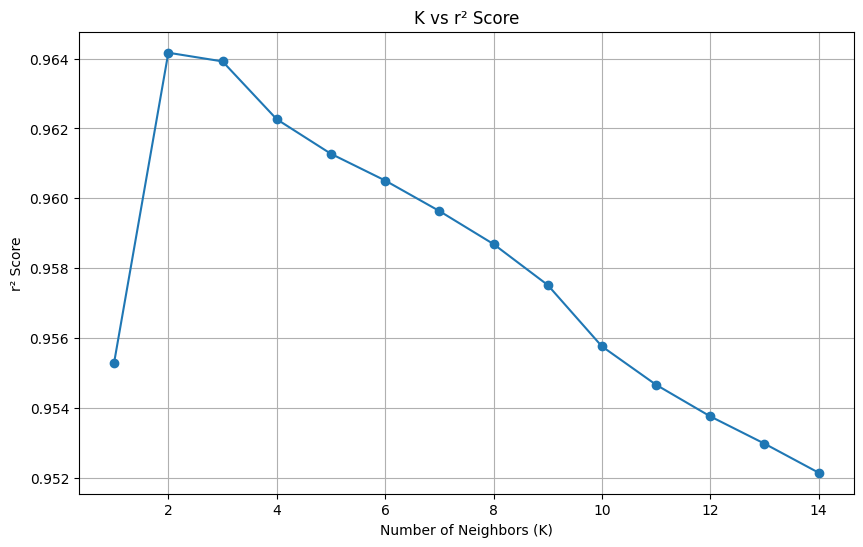

In [50]:
k_values = list(range(1, 15))
mean_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='r2')
    mean_score = np.mean(scores)
    mean_scores.append(mean_score)

plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_scores, marker='o')
plt.title('K vs r² Score')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('r² Score')
plt.grid(True)
plt.show()

In [51]:
# Use the best parameters from the Grid Search
best_n_neighbors = best_params['n_neighbors']

# Instantiate KNN model with the optimal number of neighbors
knn_best = KNeighborsRegressor(n_neighbors=best_n_neighbors)

# Training model on the scaled training data
knn_best.fit(X_train_scaled, y_train)

# Predictions on test data
y_pred = knn_best.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")

RMSE: 3.436619728382038
R^2 Score: 0.975956188699227


- RMSE : on average, the difference between the predicted and actual fare amounts is about 3.43 units 
- R2 Score : 97.4% of the changes in fare amount can be predicted by model based on the features you provided